In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = False
X=7
currency_pair = 'SEK=X'
numbers_in_currency = 'SEK'
share_name = 'DUNI.ST'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../csv_files/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2007-06-30,971,-737,234,34,112,653,503,1482,1199,...,3535,256,15,0,769,1234,2235,33,-25,47
1,2007-09-30,966,-716,250,38,172,644,561,1575,1199,...,3619,297,0,30,876,1179,2286,48,-91,47
2,2007-12-31,1125,-809,316,59,202,546,500,1455,1199,...,3514,305,0,0,787,1092,2098,302,8,47
3,2008-03-31,969,-705,264,45,114,520,556,1394,1119,...,3446,295,0,0,735,1042,1997,-7,-31,47
4,2008-06-30,1012,-752,260,57,128,548,556,1428,1199,...,3491,304,0,0,749,1094,2066,80,-37,47


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
62,2022-12-31,2023-02-11,47,1974,-1573,401,59,372,1137,1727,...,305,7339,840,0,393,2076,1173,4127,231,-64
63,2023-03-31,2023-04-21,47,1877,-1486,391,90,323,1196,1578,...,287,7304,623,0,347,1854,1298,4028,4,-22
64,2023-06-30,2023-07-21,47,1936,-1496,440,120,419,1259,1469,...,274,7492,601,0,362,2073,1230,4191,355,-19
65,2023-09-30,2023-10-21,47,1935,-1442,493,150,345,1234,1337,...,253,7211,577,0,353,2099,832,3821,371,-65
66,2023-12-31,2024-02-11,47,1971,-1441,530,83,488,1125,1251,...,230,6913,719,0,342,2046,610,3491,460,-59


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
62,2022-12-31,2023-02-11,47,1974,-1573,401,59,372,1137,1727,...,7339,840,0,393,2076,1173,4127,231,-64,10.721097
63,2023-03-31,2023-04-21,47,1877,-1486,391,90,323,1196,1578,...,7304,623,0,347,1854,1298,4028,4,-22,10.432528
64,2023-06-30,2023-07-21,47,1936,-1496,440,120,419,1259,1469,...,7492,601,0,362,2073,1230,4191,355,-19,10.518236
65,2023-09-30,2023-10-21,47,1935,-1442,493,150,345,1234,1337,...,7211,577,0,353,2099,832,3821,371,-65,10.805716
66,2023-12-31,2024-02-11,47,1971,-1441,530,83,488,1125,1251,...,6913,719,0,342,2046,610,3491,460,-59,10.657495


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
62,2022-12-31,2023-02-11,47,1974,-1573,401,59,372,1137,1727,...,7339,840,0,393,2076,1173,4127,231,-64,10.721097
63,2023-03-31,2023-04-21,47,1877,-1486,391,90,323,1196,1578,...,7304,623,0,347,1854,1298,4028,4,-22,10.432528
64,2023-06-30,2023-07-21,47,1936,-1496,440,120,419,1259,1469,...,7492,601,0,362,2073,1230,4191,355,-19,10.518236
65,2023-09-30,2023-10-21,47,1935,-1442,493,150,345,1234,1337,...,7211,577,0,353,2099,832,3821,371,-65,10.805716
66,2023-12-31,2024-02-11,47,1971,-1441,530,83,488,1125,1251,...,6913,719,0,342,2046,610,3491,460,-59,10.657495


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2007-11-12,25.267338,2007-09-30,966,3.234043,28.361702,47,556,11.829787,172,...,0.368334,0.631666,6.0,9.643098,22.465116,5.105169,0.258799,0.039337,0.042001,0.114029
1,2007-11-19,24.225395,2007-09-30,966,3.234043,28.361702,47,556,11.829787,172,...,0.368334,0.631666,6.0,9.643098,22.465116,5.105169,0.258799,0.039337,0.042001,0.114029
2,2007-11-26,25.527822,2007-09-30,966,3.234043,28.361702,47,556,11.829787,172,...,0.368334,0.631666,6.0,9.643098,22.465116,5.105169,0.258799,0.039337,0.042001,0.114029
3,2007-12-03,25.788313,2007-09-30,966,3.234043,28.361702,47,556,11.829787,172,...,0.368334,0.631666,6.0,9.643098,22.465116,5.105169,0.258799,0.039337,0.042001,0.114029
4,2007-12-10,26.179047,2007-09-30,966,3.234043,28.361702,47,556,11.829787,172,...,0.368334,0.631666,6.0,9.643098,22.465116,5.105169,0.258799,0.039337,0.042001,0.114029


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2007-11-12,25.267338,2007-09-30,966,3.234043,28.361702,47,556,11.829787,172,...,5.105169,0.258799,0.039337,0.042001,0.114029,7.812927,0.890896,0.307341,0.854442,2.135908
1,2007-11-19,24.225395,2007-09-30,966,3.234043,28.361702,47,556,11.829787,172,...,5.105169,0.258799,0.039337,0.042001,0.114029,7.490747,0.854159,0.294667,0.841769,2.047830
2,2007-11-26,25.527822,2007-09-30,966,3.234043,28.361702,47,556,11.829787,172,...,5.105169,0.258799,0.039337,0.042001,0.114029,7.893471,0.900081,0.310509,0.857611,2.157927
3,2007-12-03,25.788313,2007-09-30,966,3.234043,28.361702,47,556,11.829787,172,...,5.105169,0.258799,0.039337,0.042001,0.114029,7.974018,0.909265,0.313678,0.860779,2.179947
4,2007-12-10,26.179047,2007-09-30,966,3.234043,28.361702,47,556,11.829787,172,...,5.105169,0.258799,0.039337,0.042001,0.114029,8.094837,0.923042,0.318430,0.865532,2.212977


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

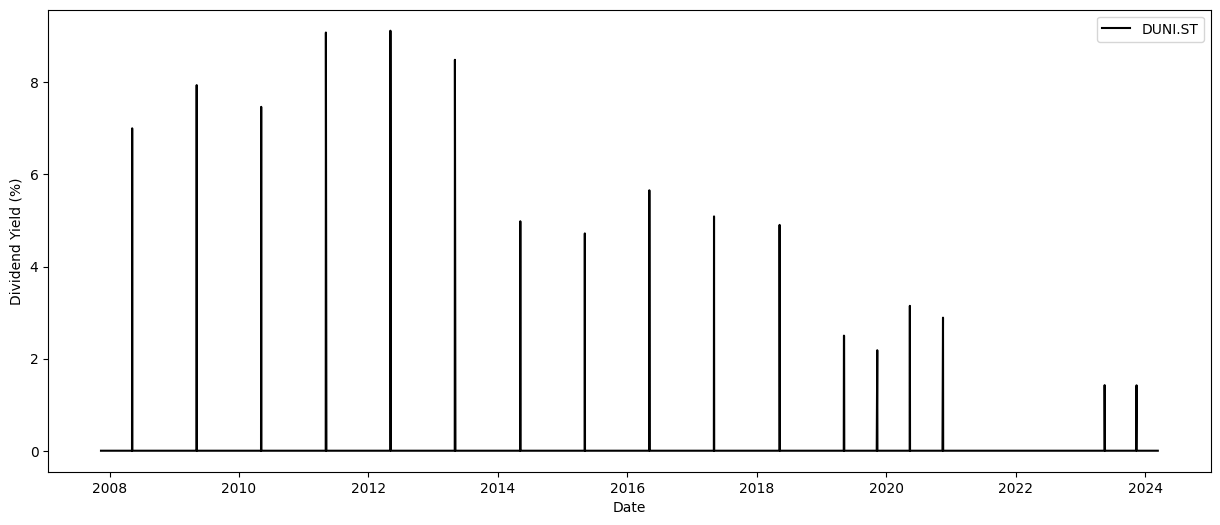

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.716454
share_price      1.000000
Name: share_price, dtype: float64


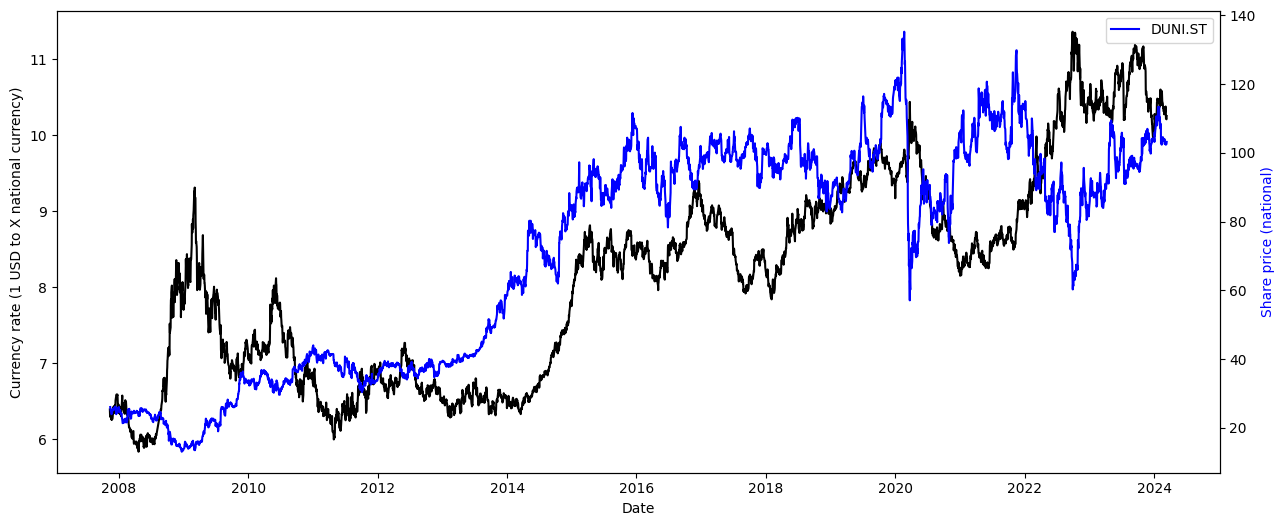

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

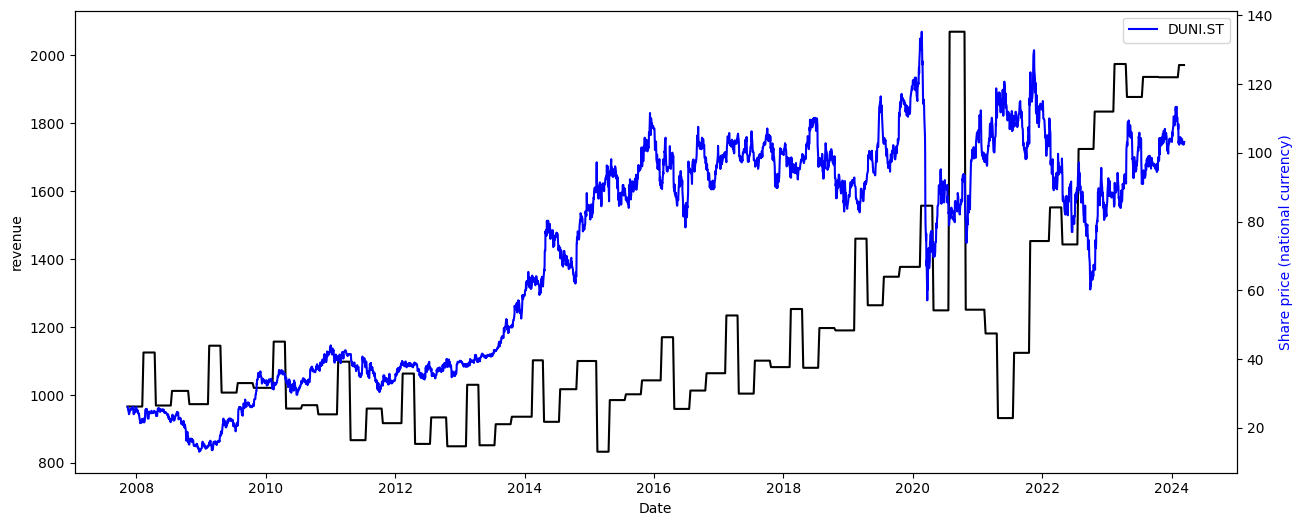

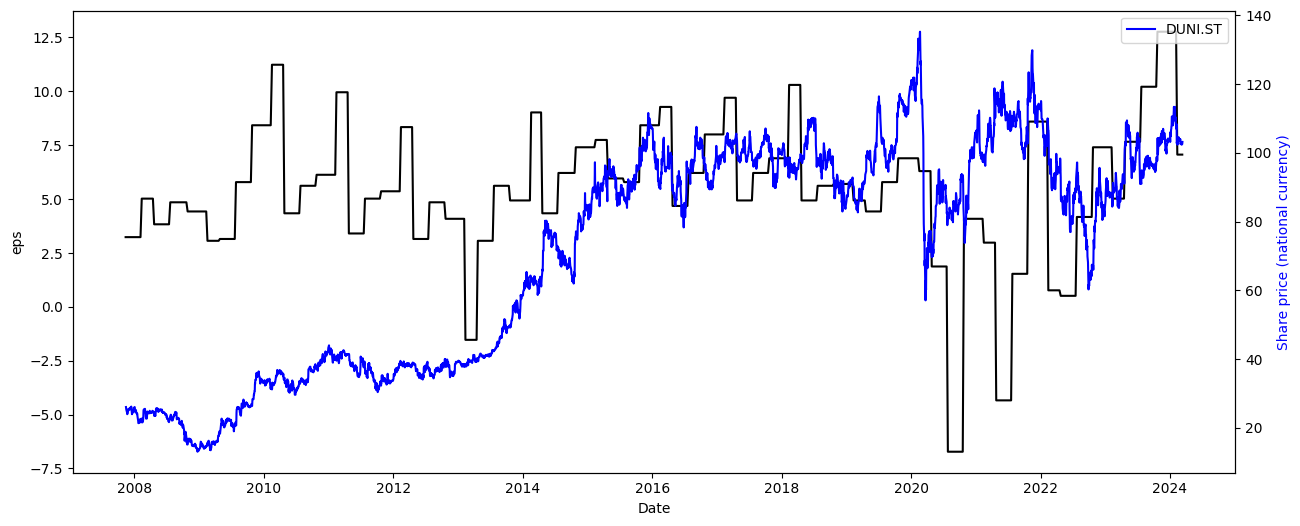

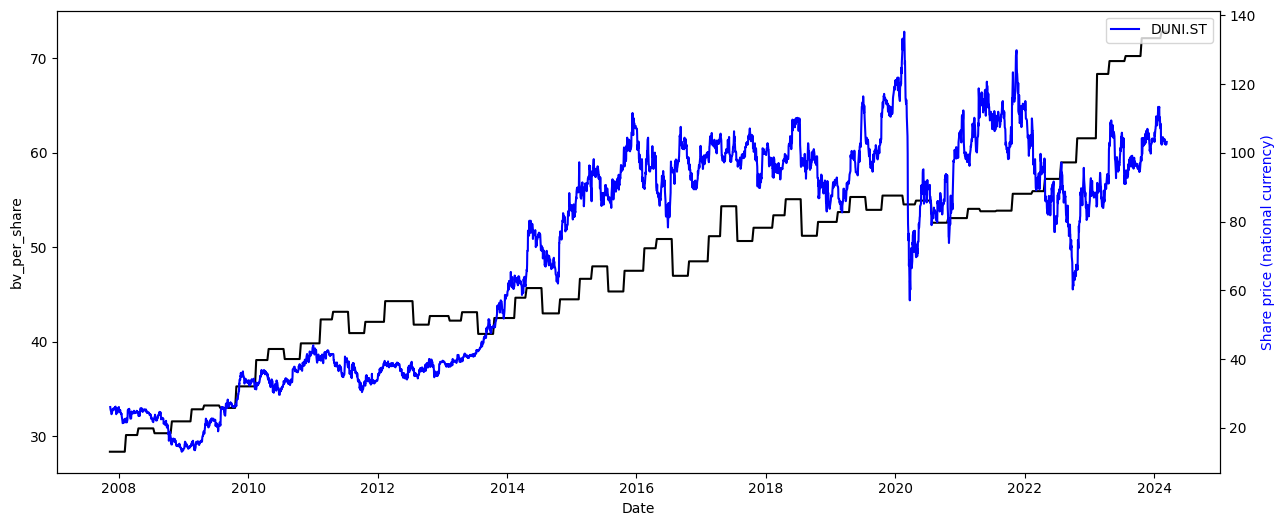

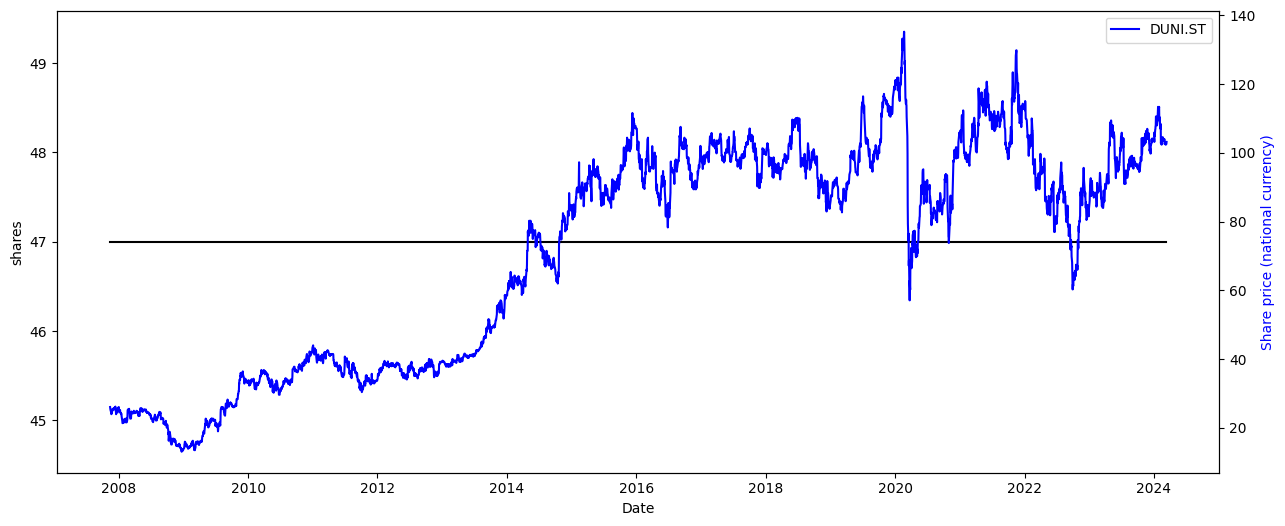

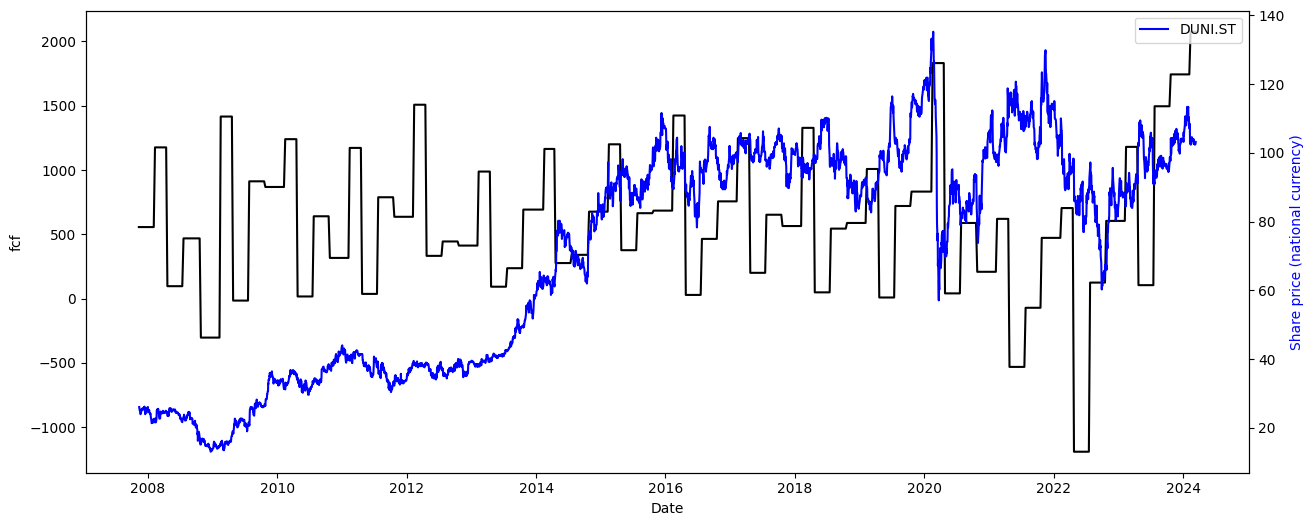

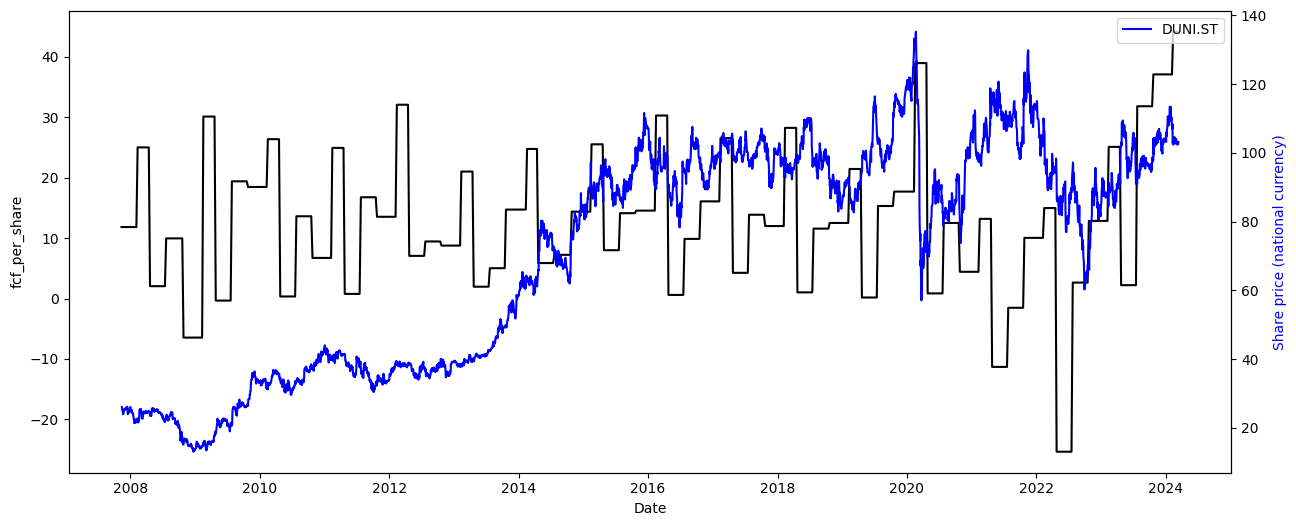

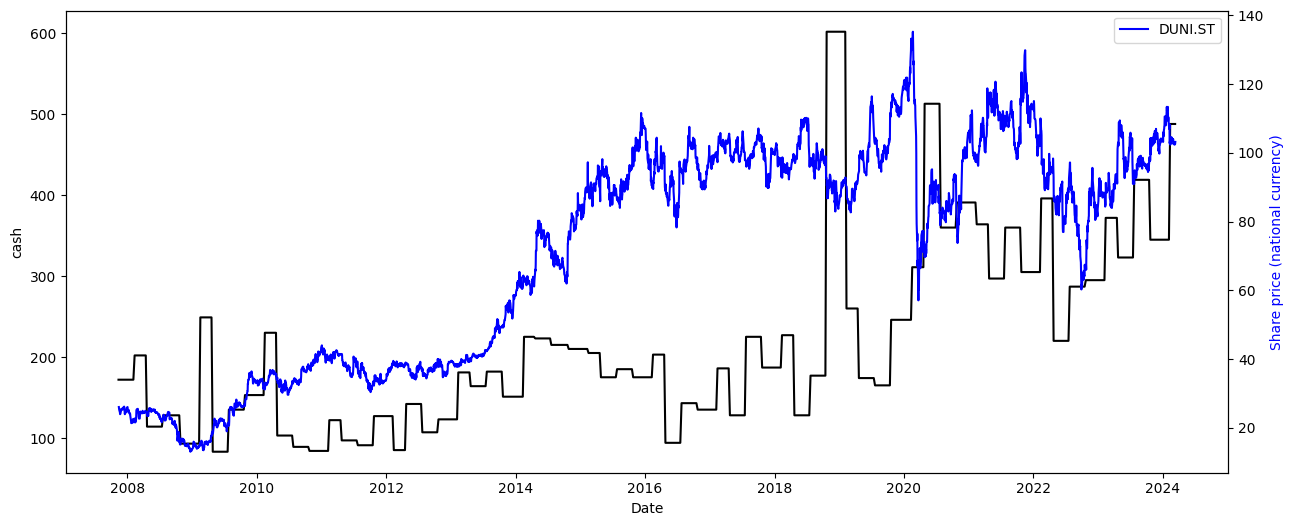

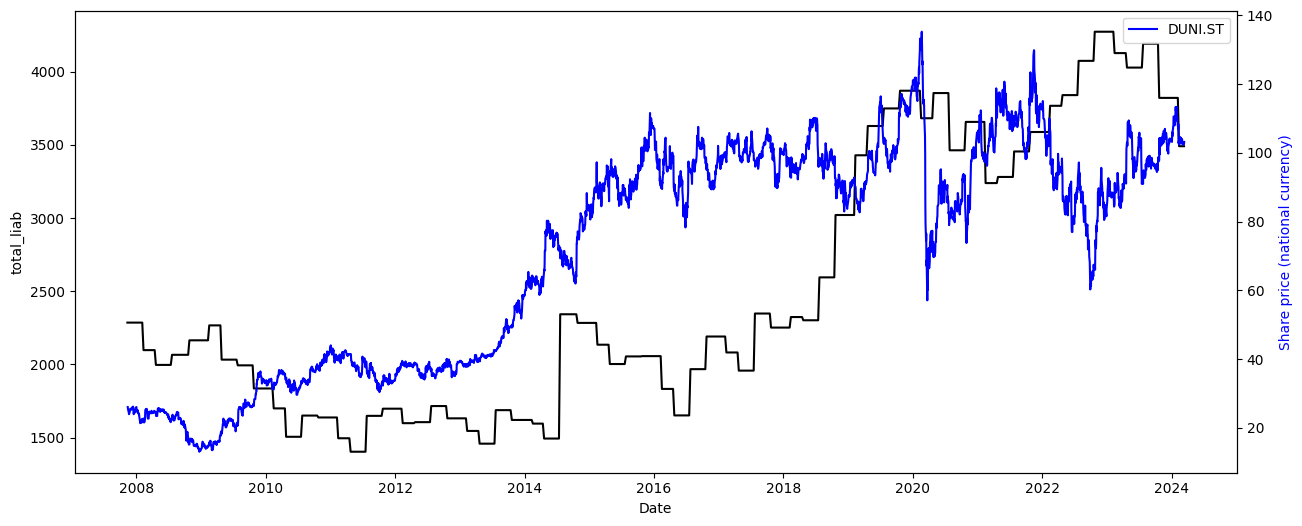

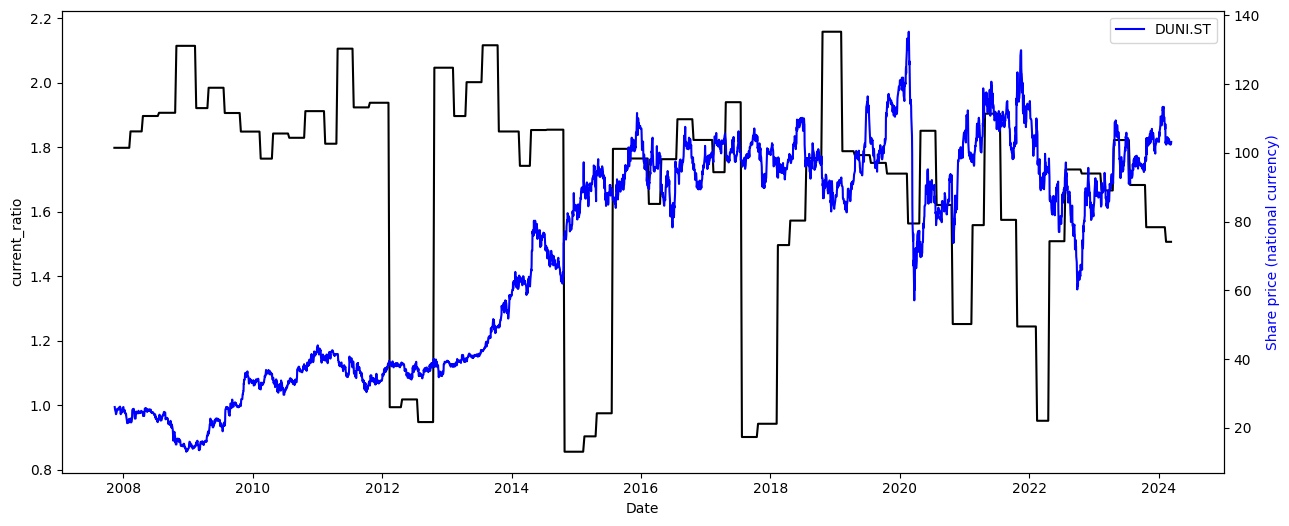

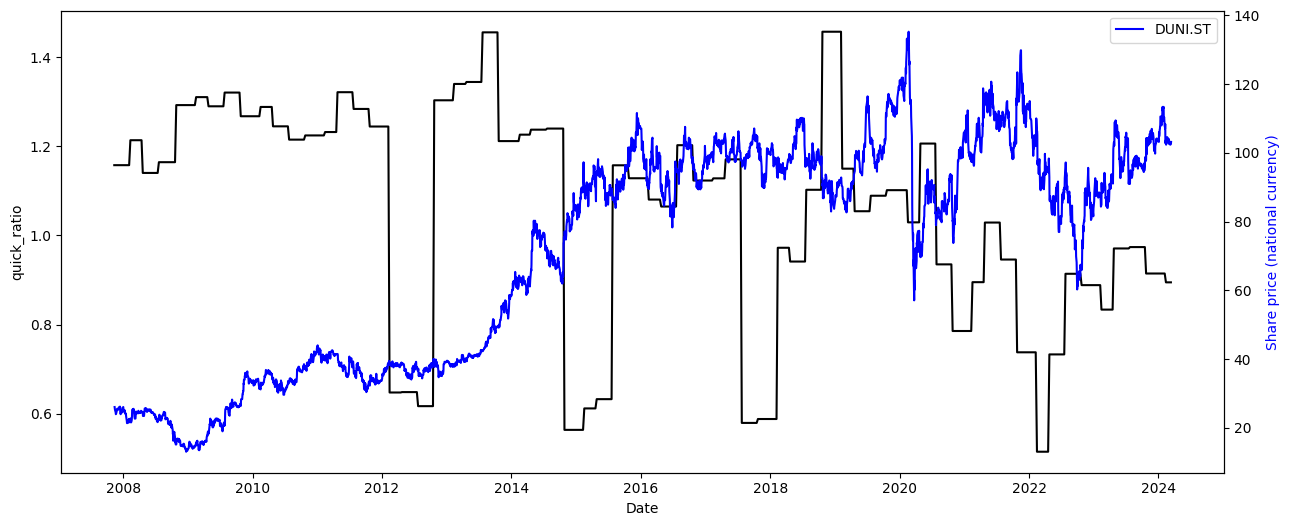

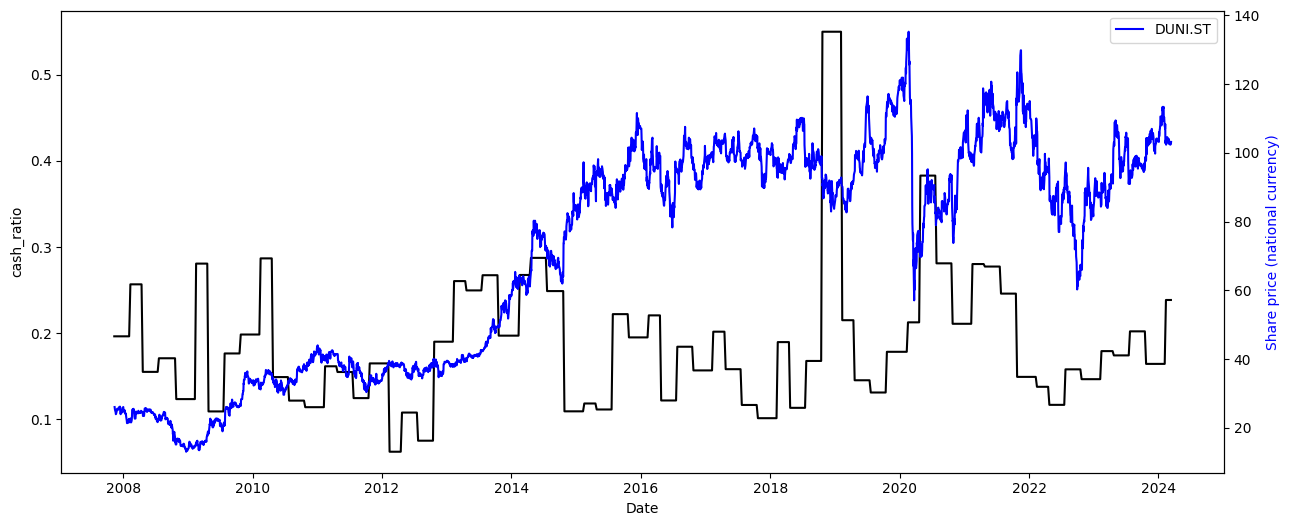

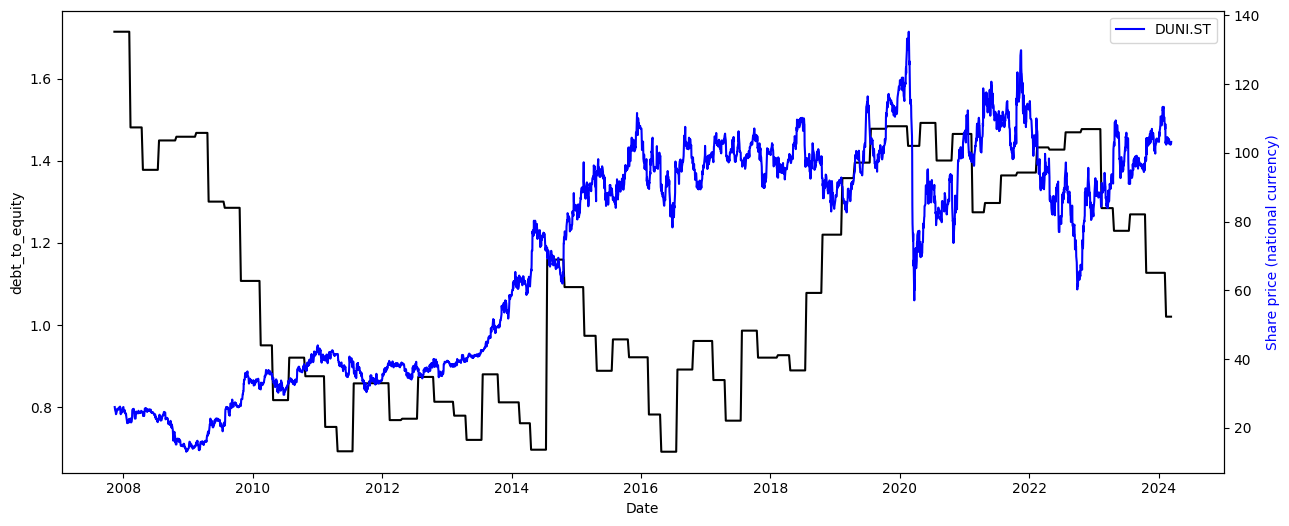

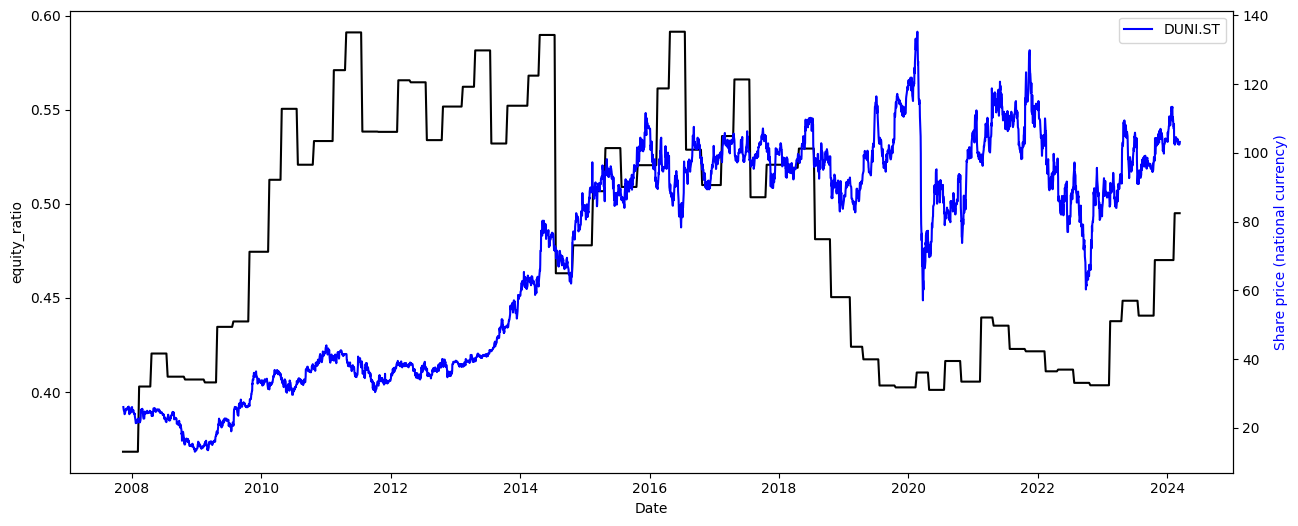

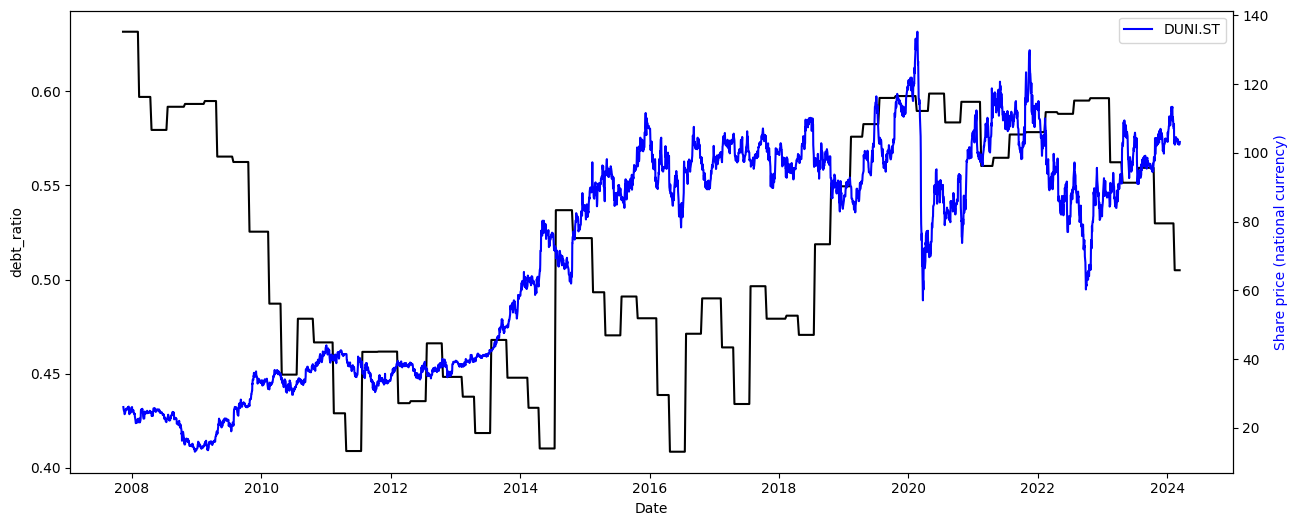

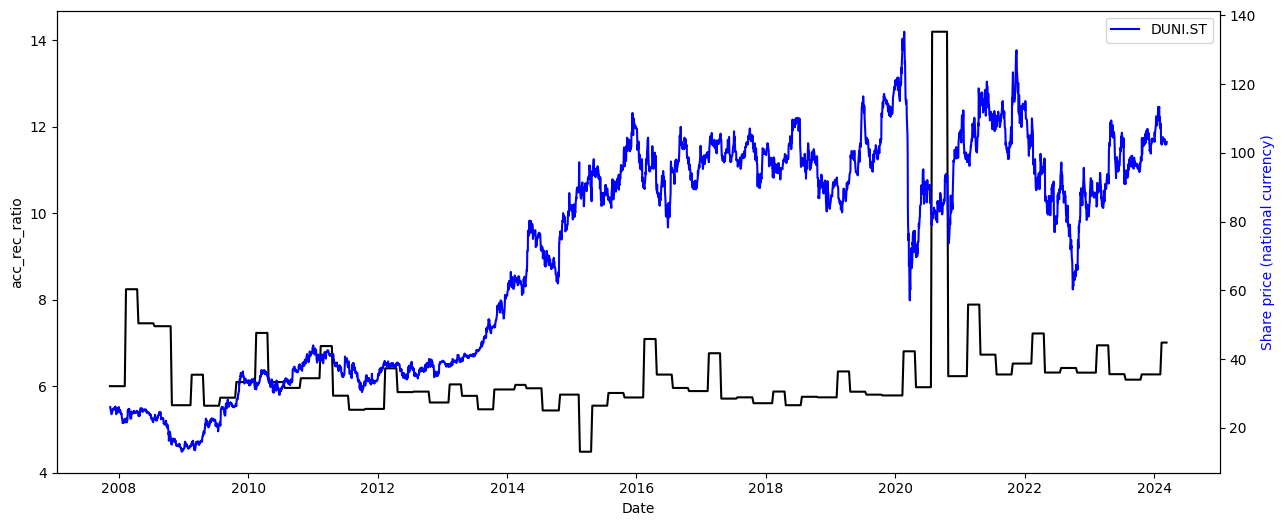

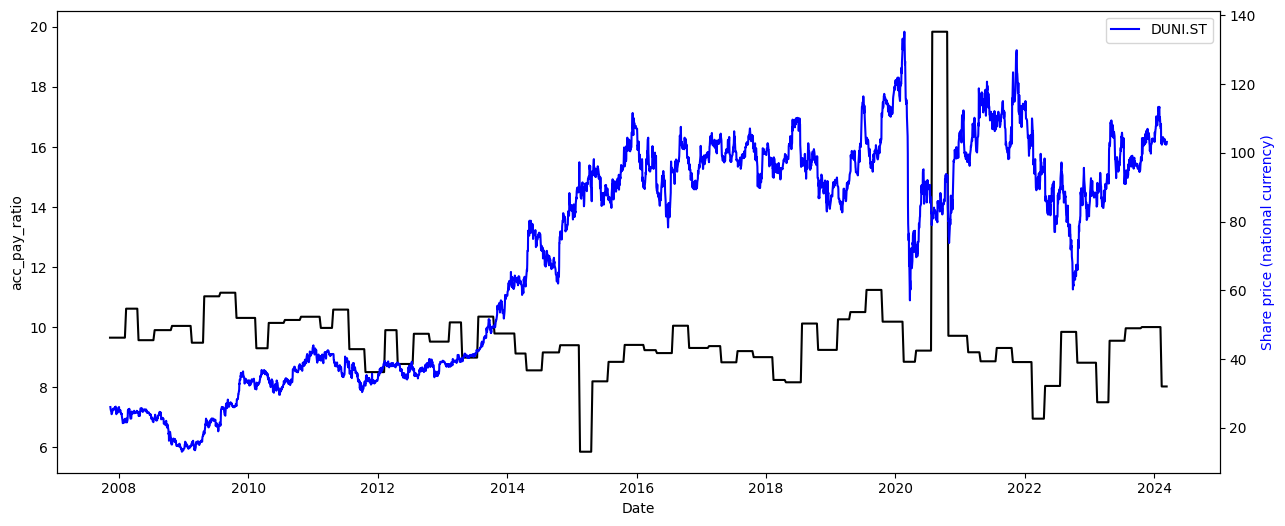

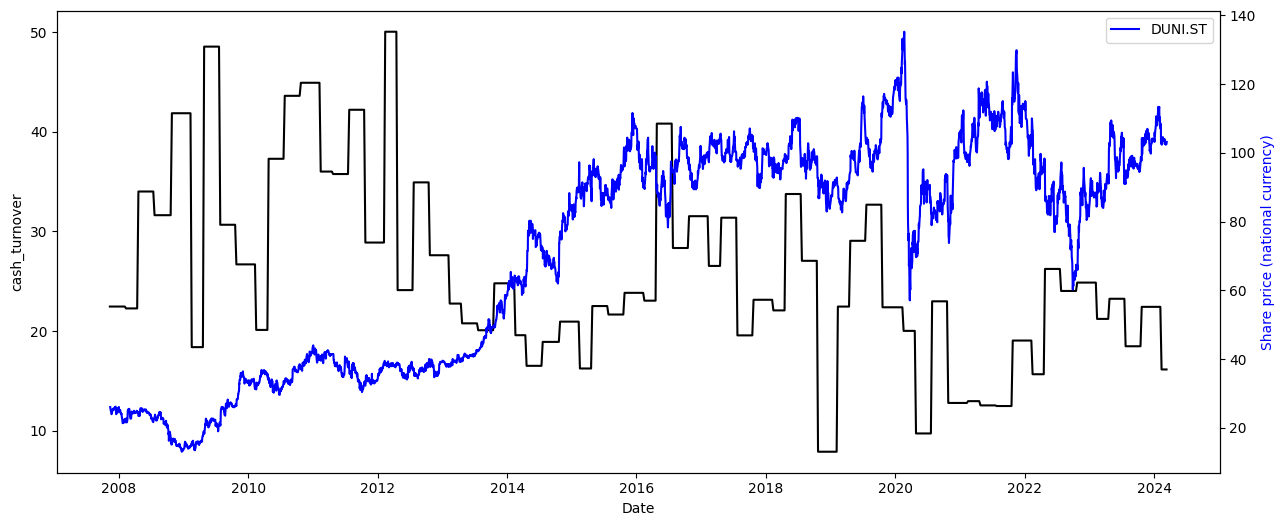

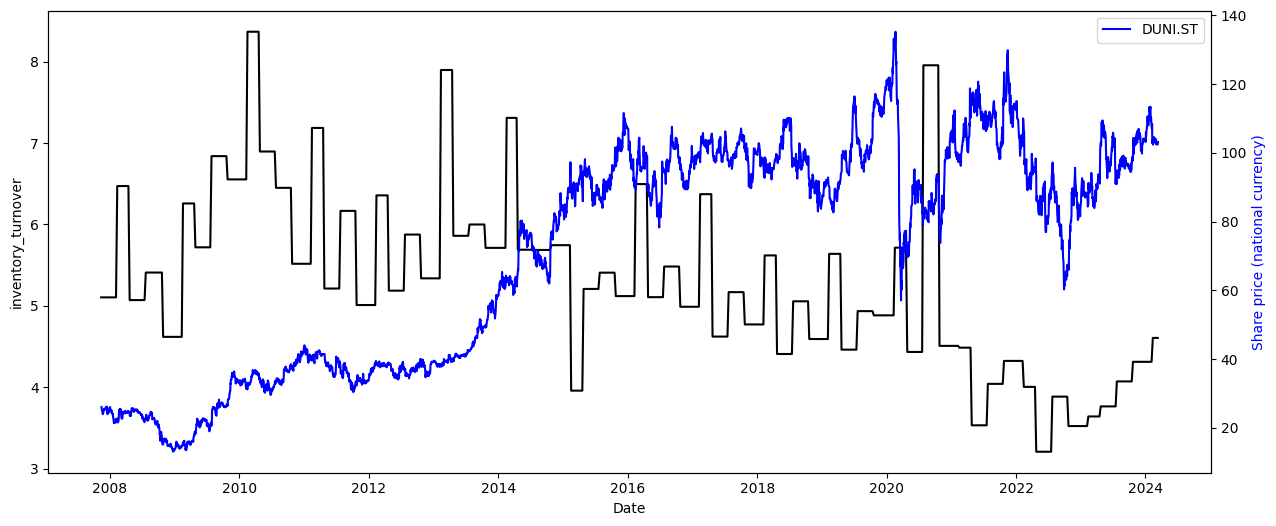

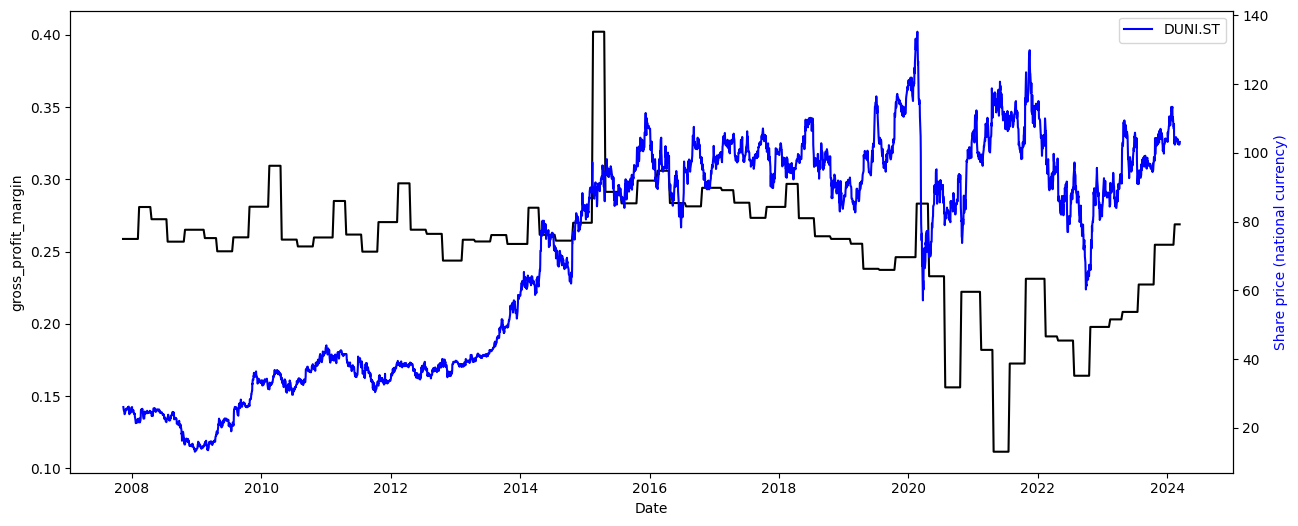

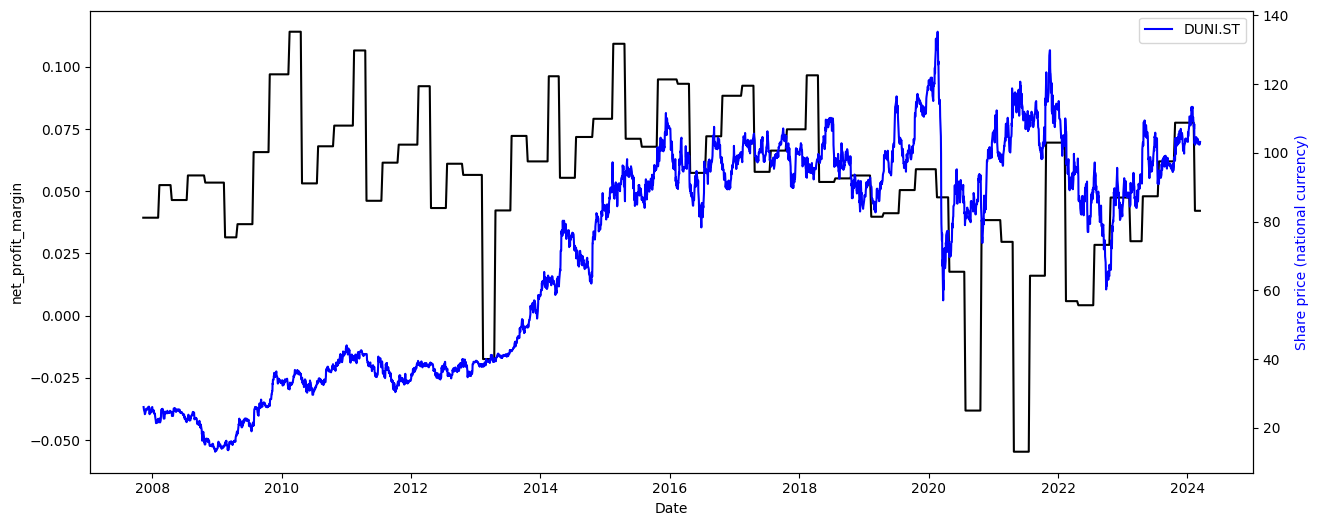

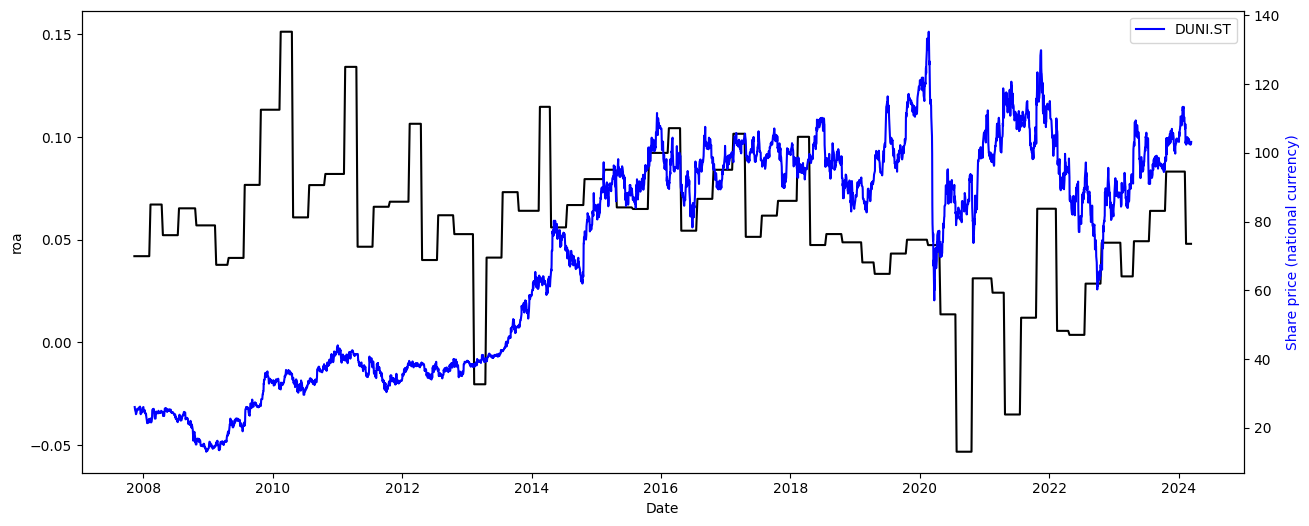

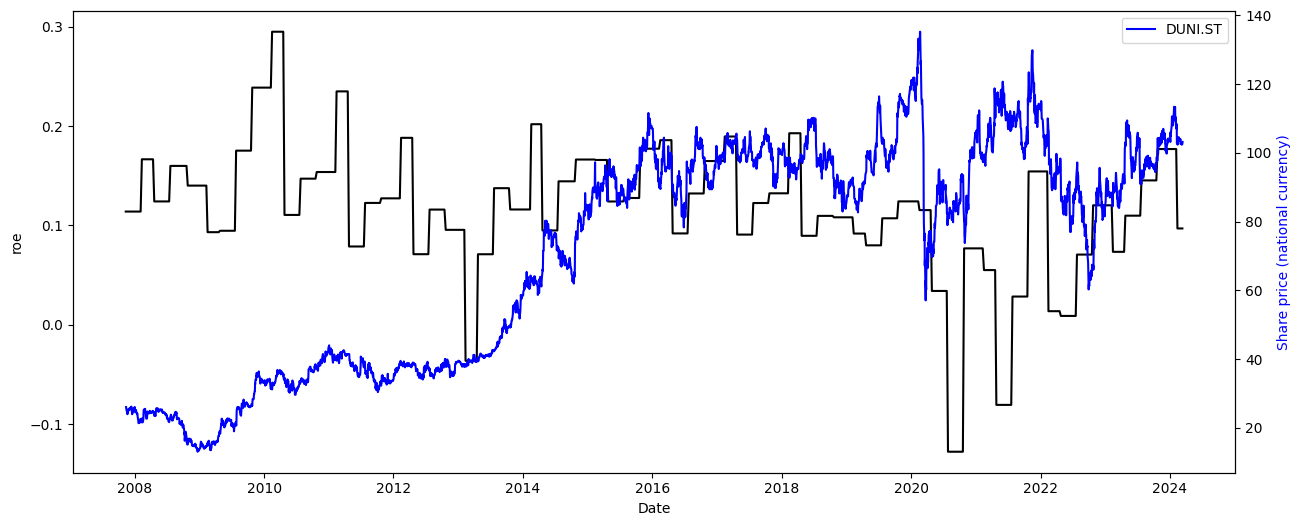

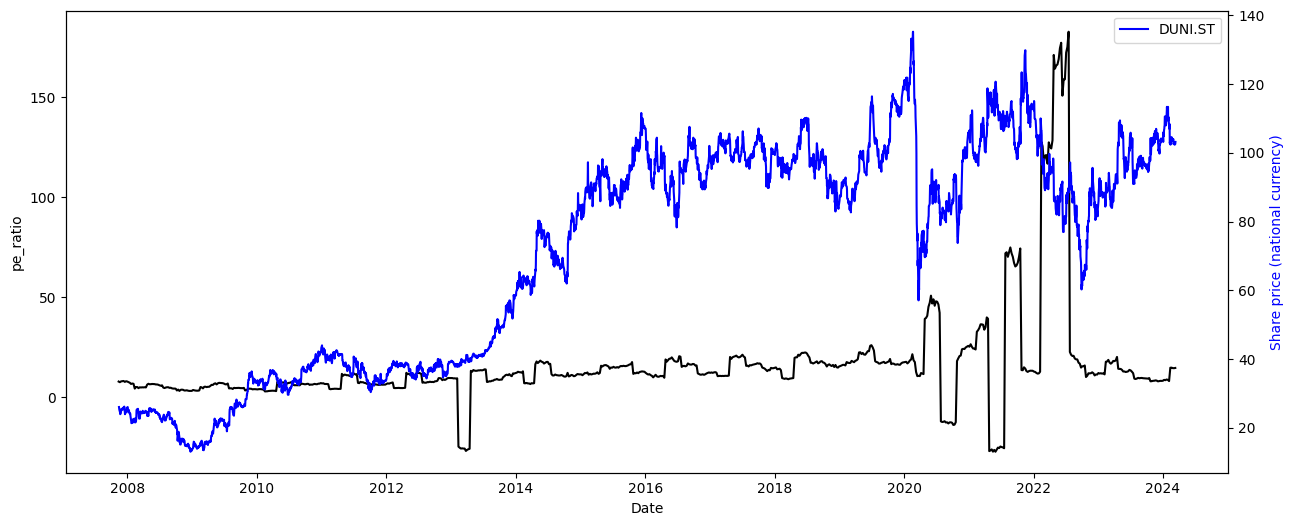

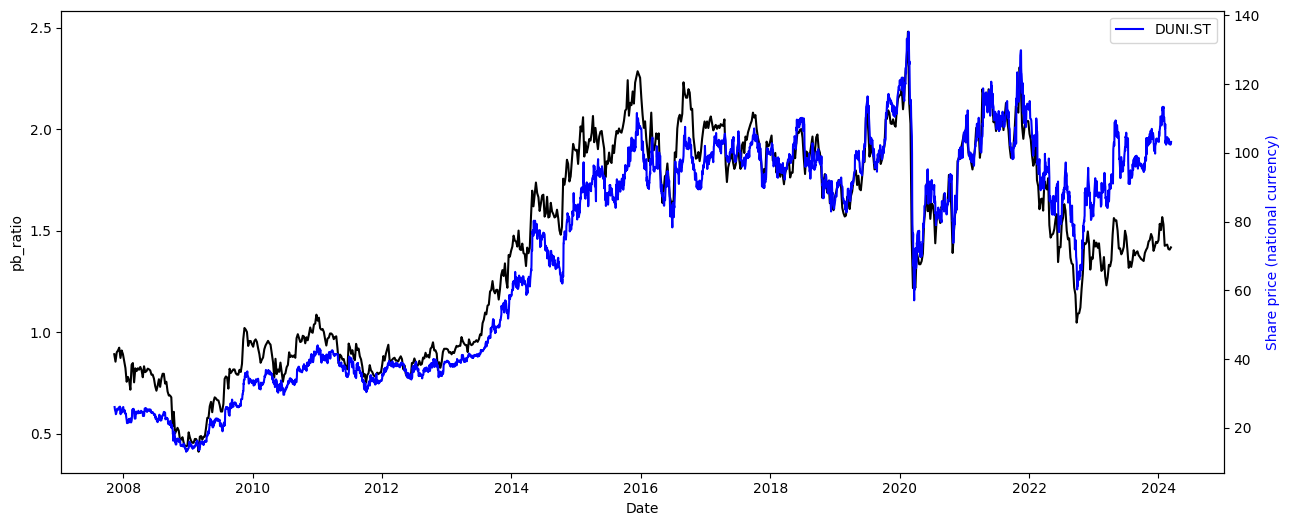

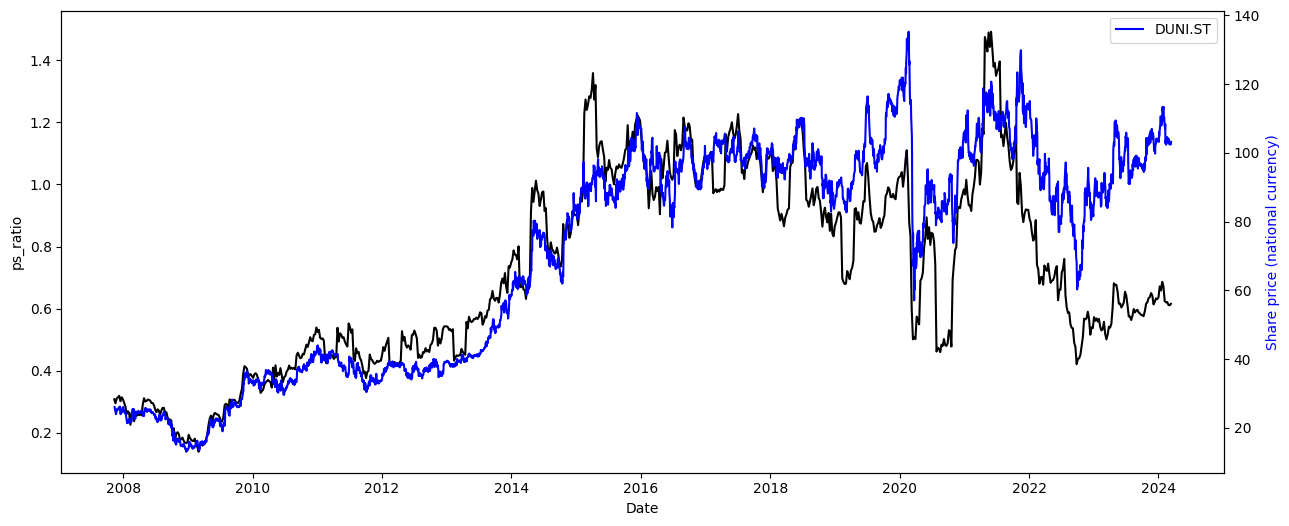

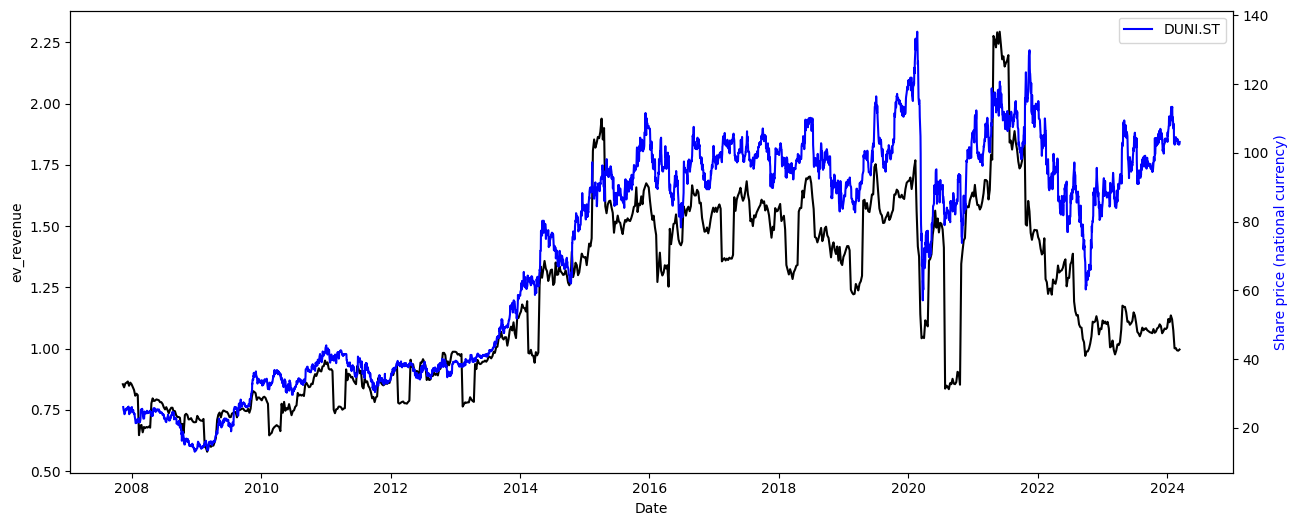

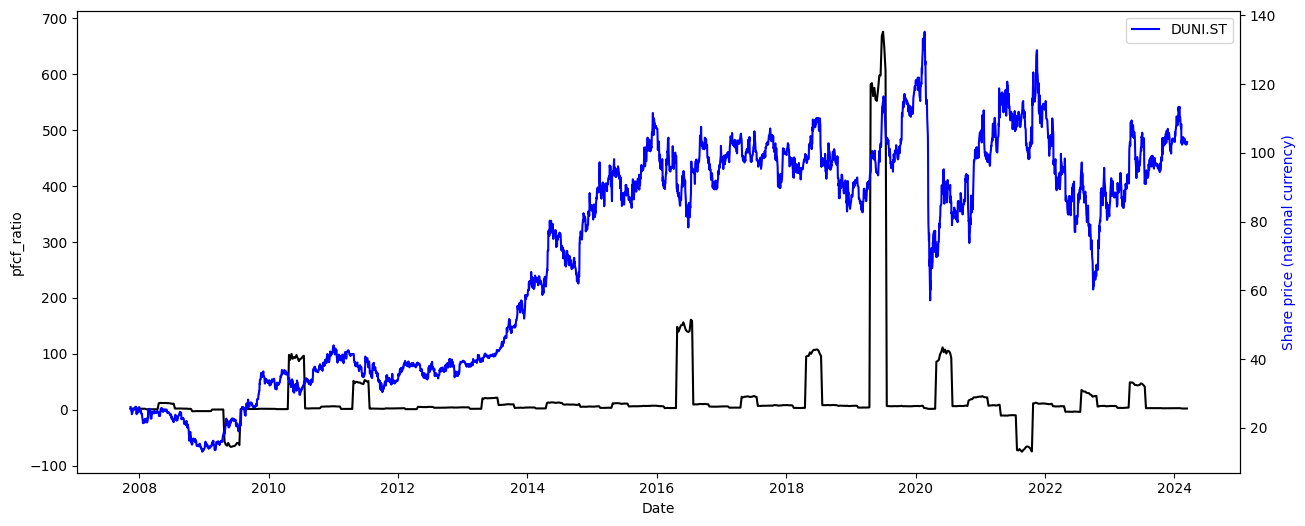

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

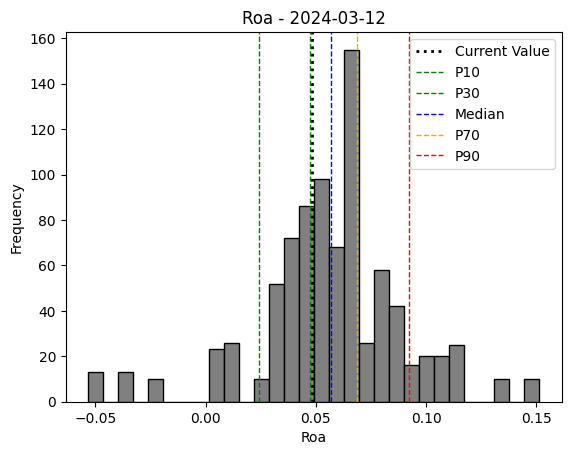

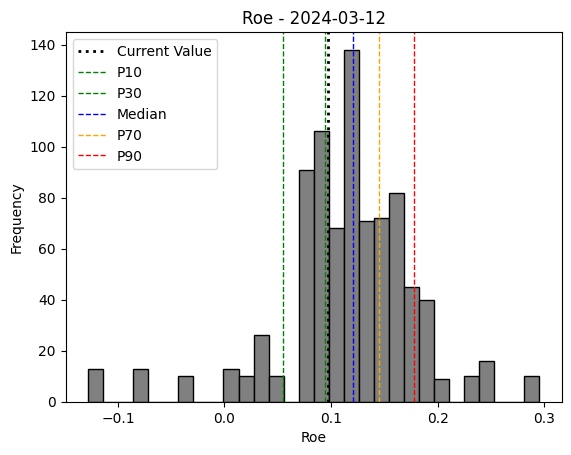

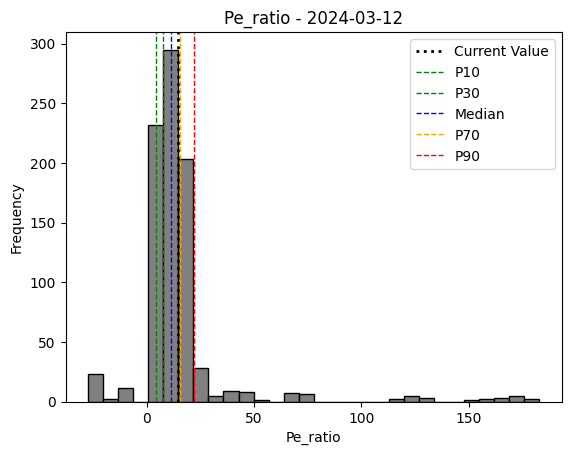

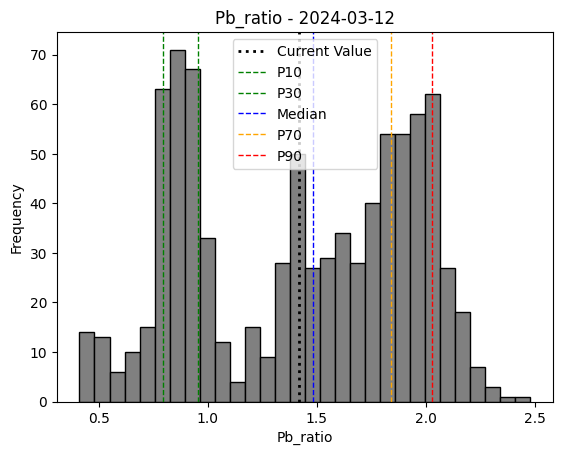

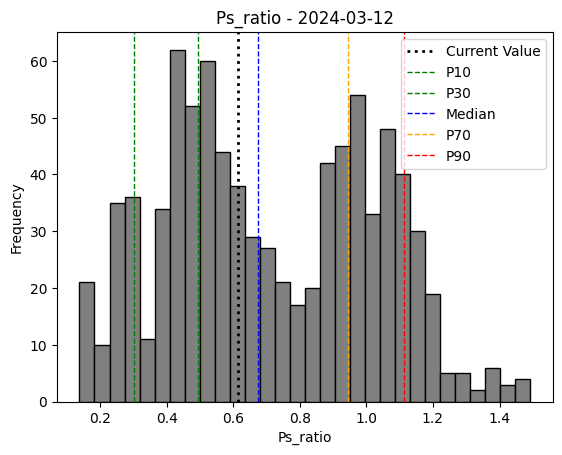

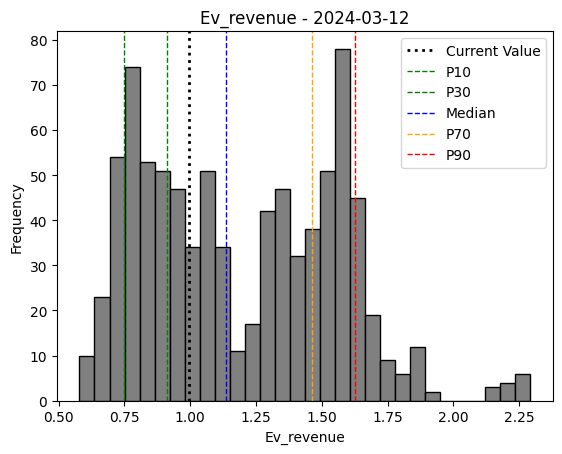

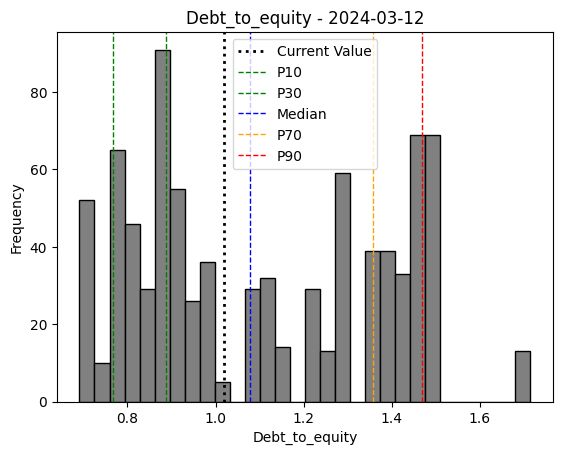

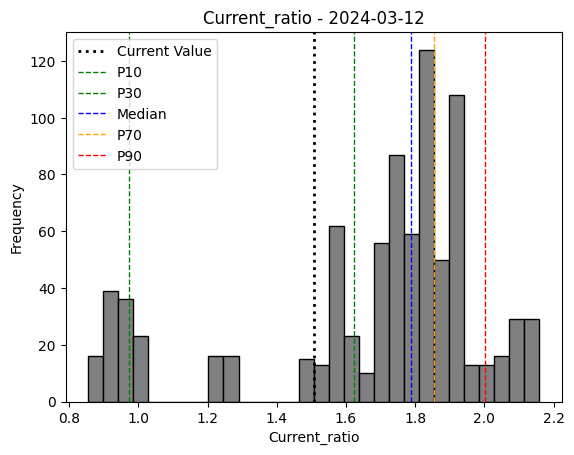

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.973906,-0.236290,-0.117023,-0.096117,-0.224440,-0.433955,-0.038477
roe,0.973906,1.000000,-0.227863,-0.139610,-0.154170,-0.242114,-0.248181,-0.023191
pe_ratio,-0.236290,-0.227863,1.000000,0.219958,0.171914,0.241353,0.232550,-0.221654
pb_ratio,-0.117023,-0.139610,0.219958,1.000000,0.938071,0.922456,0.031504,-0.345533
ps_ratio,-0.096117,-0.154170,0.171914,0.938071,1.000000,0.967243,-0.170500,-0.306946
ev_revenue,-0.224440,-0.242114,0.241353,0.922456,0.967243,1.000000,0.048328,-0.294346
debt_to_equity,-0.433955,-0.248181,0.232550,0.031504,-0.170500,0.048328,1.000000,0.021625
current_ratio,-0.038477,-0.023191,-0.221654,-0.345533,-0.306946,-0.294346,0.021625,1.000000


5 timestemos have been found!


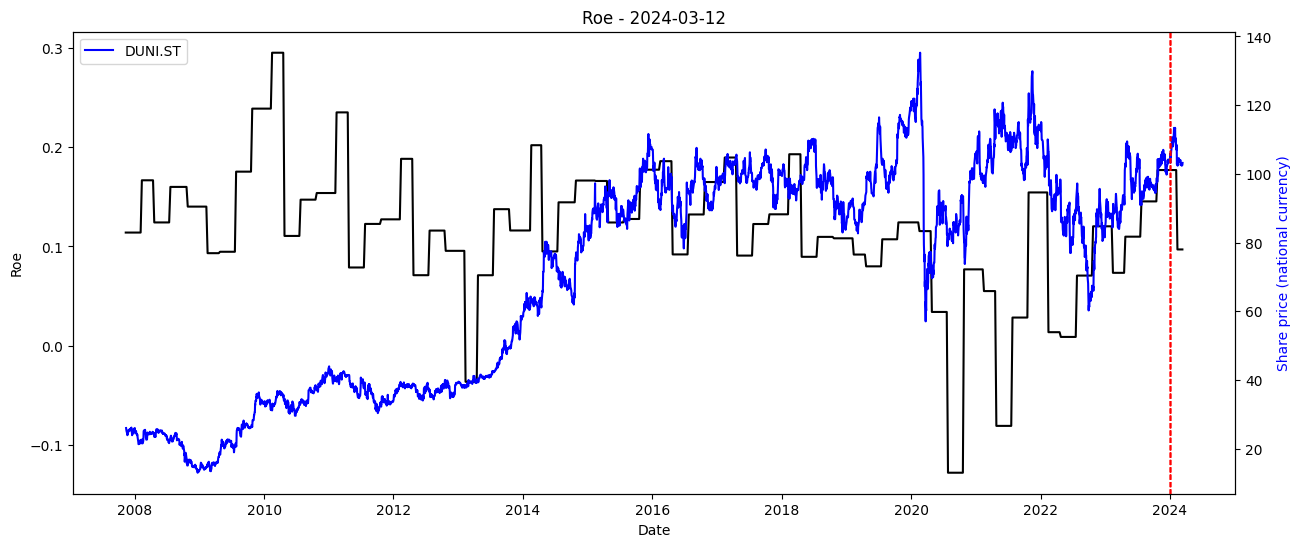

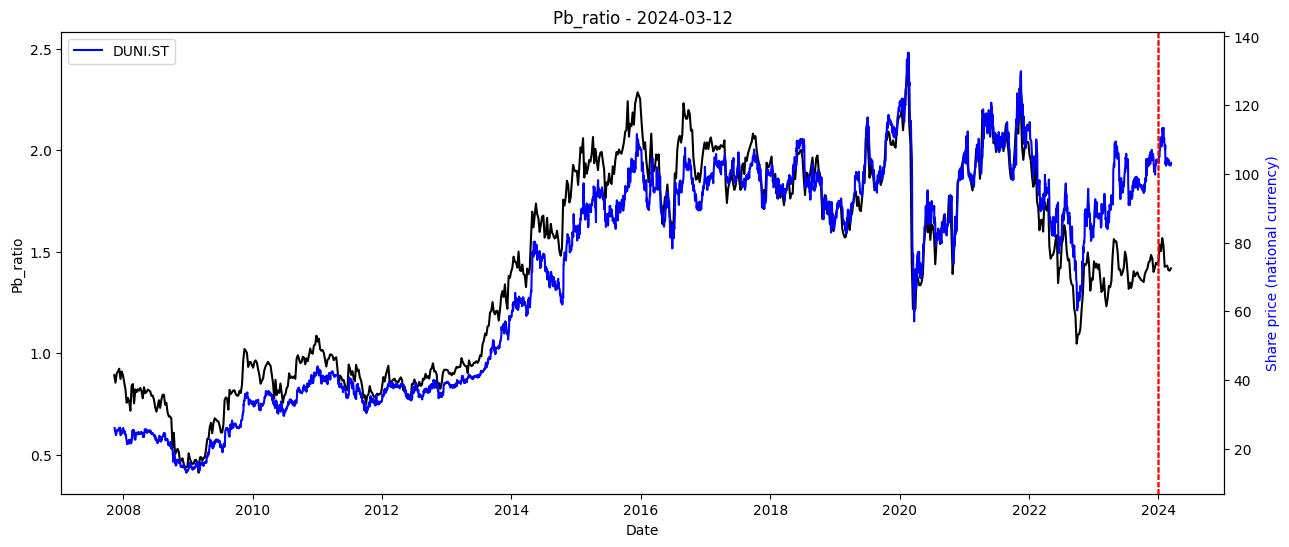

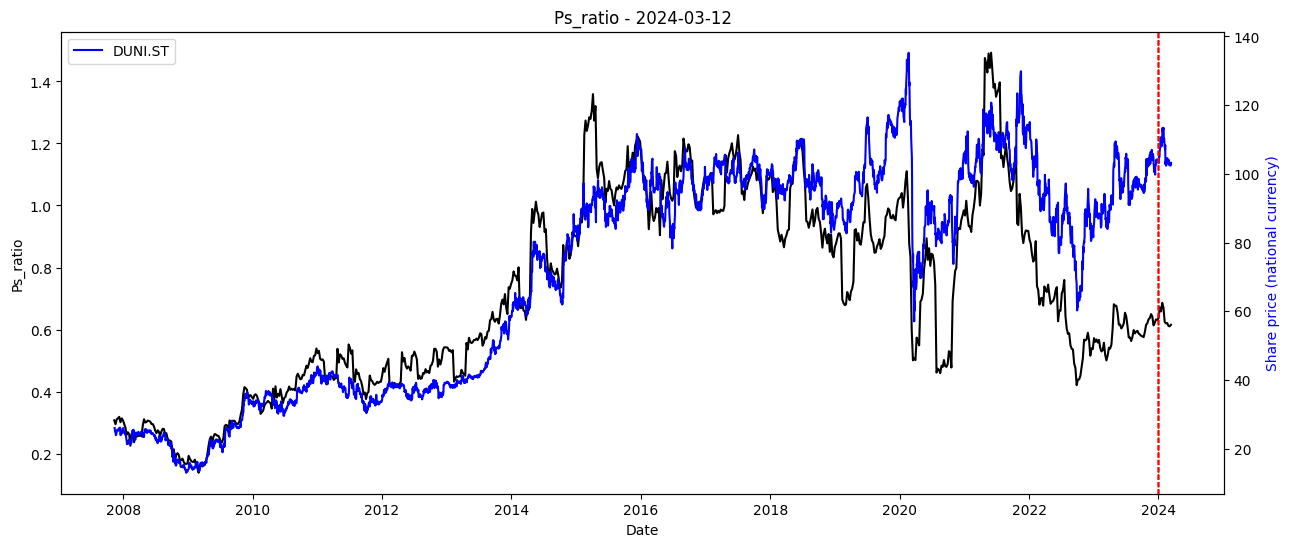

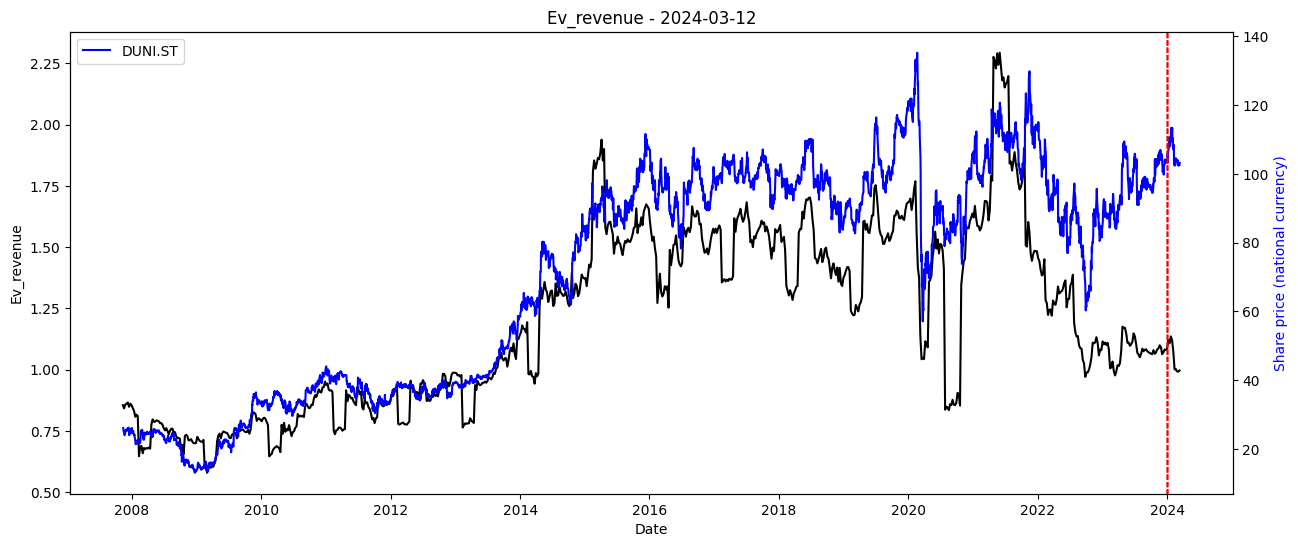

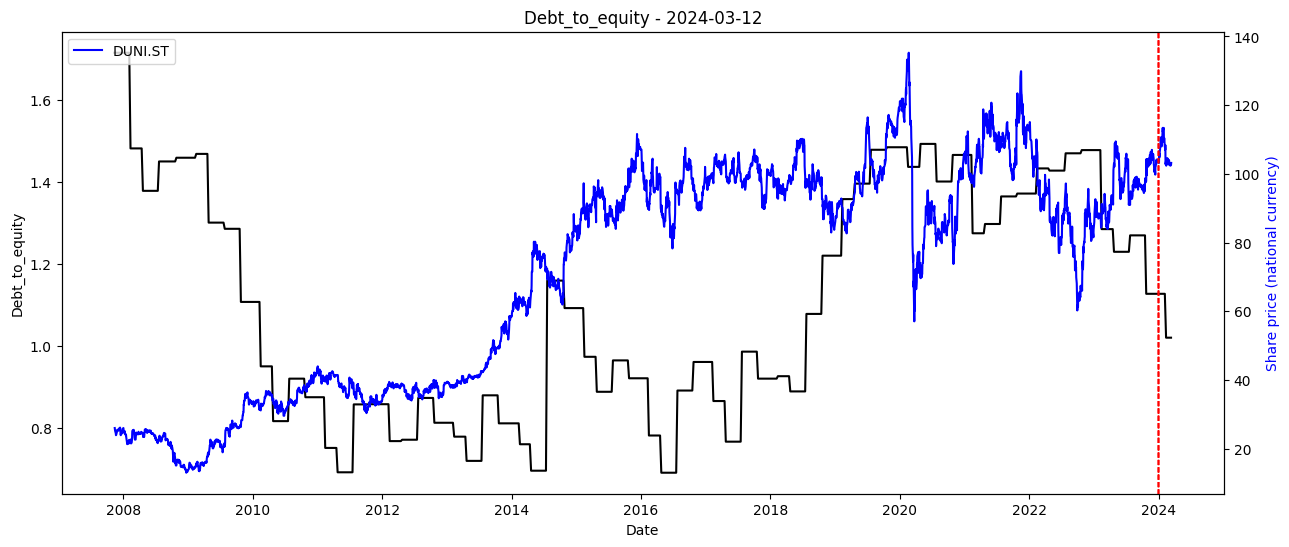

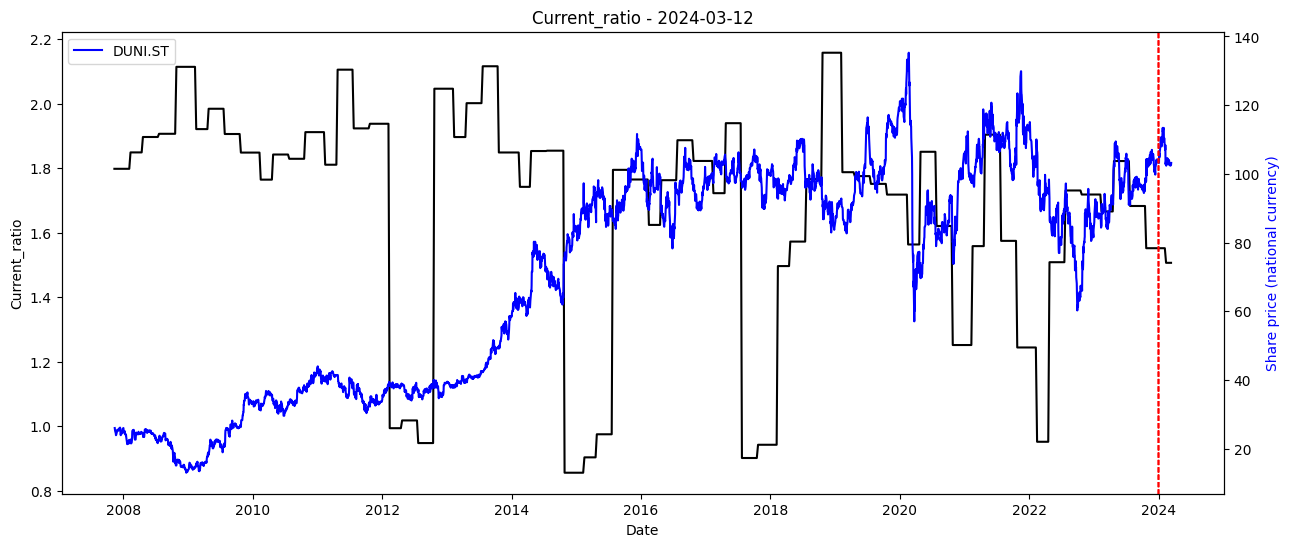

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )